## High Tide Flooding Outlook:  API Retrieval and Plotting

Written by Julia Engdahl - julia.engdahl@noaa.gov



We will be using the Center for Operational Oceanographic Products and Services (CO-OPS) Derived Product API (DPAPI)

Input and output documentation can be found in the [CO-OPS Derived Product API v0.1](https://api.tidesandcurrents.noaa.gov/dpapi/prod/) and the [CO-OPS Metadata API](https://api.tidesandcurrents.noaa.gov/mdapi/prod/).


Standard templates are available within the [CO-OPS API URL Builder](https://tidesandcurrents.noaa.gov/api-helper/url-generator.html), but this notebook is designed to give you more flexiblity through building our own api template to generate queries from our Data API, MetaData API, and Derived Product API.


#### You'll need the following packages to plot each visualization. 

In [1]:
import datetime as dt
import requests
import time as time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calplot
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

#### From there, we'll build our template for retreiving High Tide Flooding Annual Flood Counts from the DPAPI. This step will create flexibility in the way you can pull and visualize data.   

In [2]:
product = "htf_annual"
units='english'
year = '2009'
yrange='10'
station_id='8443970'
server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/htf/"

my_url = (server+product+ ".json?"+'station='+station_id+'&year='+year+'&range='+yrange+'&units='+units)

urlResponse = requests.get(my_url)
content=urlResponse.json()

mydata=content['AnnualFloodCount']
annflood = pd.DataFrame(mydata)
annflood

,stnId,stnName,year,majCount,modCount,minCount,nanCount
0,8443970,"Boston, MA",2009,0,0,9,9
1,8443970,"Boston, MA",2010,0,2,21,0
2,8443970,"Boston, MA",2011,0,0,19,0
3,8443970,"Boston, MA",2012,0,2,12,0
4,8443970,"Boston, MA",2013,0,0,14,0
5,8443970,"Boston, MA",2014,0,1,6,0
6,8443970,"Boston, MA",2015,0,1,6,0
7,8443970,"Boston, MA",2016,0,0,16,0
8,8443970,"Boston, MA",2017,0,0,15,6
9,8443970,"Boston, MA",2018,2,3,25,0


#### The following module plots a time series of Annual High Tide Flood Counts per scenario and by station. 

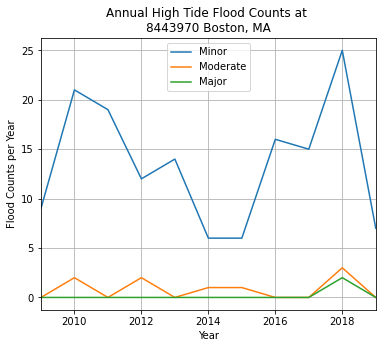

In [3]:
plt.figure(figsize=(6,5))
plt.plot(annflood['year'],annflood['minCount'], label='Minor')
plt.plot(annflood['year'],annflood['modCount'], label='Moderate')
plt.plot(annflood['year'],annflood['majCount'], label='Major')
plt.xlim(annflood['year'].iloc[0],annflood['year'].iloc[-1])
plt.title('Annual High Tide Flood Counts at \n'+str(annflood['stnId'][0])+' '+str(annflood['stnName'][0]))
plt.ylabel('Flood Counts per Year')
plt.xlabel('Year')
plt.grid()
plt.legend()


#### This module creates a subplot of histograms for Annual High Tide Flooding counts per scenario and by station. 

Text(0.5, 1.01, 'Annual High Tide Flood Counts at \n8443970 Boston, MA')

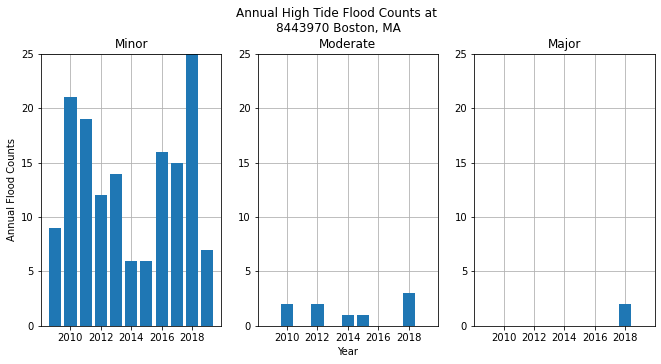

In [4]:
fig,ax = plt.subplots(1,3,figsize=(11,5))
ax[0].grid(True)
ax[0].set_axisbelow(True)
ax[0].bar(annflood['year'],annflood['minCount'])
ax[0].set_title('Minor')
ax[0].set_ylim(0,25)
ax[0].set_ylabel('Annual Flood Counts')

ax[1].grid(True)
ax[1].set_axisbelow(True)
ax[1].bar(annflood['year'],annflood['modCount'])
ax[1].set_title('Moderate')
ax[1].set_ylim(0,25)
ax[1].set_xlabel('Year')


ax[2].grid(True)
ax[2].set_axisbelow(True)
ax[2].bar(annflood['year'],annflood['majCount'])
ax[2].set_title('Major')
ax[2].set_ylim(0,25)

fig.suptitle('Annual High Tide Flood Counts at \n'+str(annflood['stnId'][0])+' '+str(annflood['stnName'][0]),y=1.01)

#### This section allows you to restructure the dataframe to enable heat map plotting by modifying the Color (C) variable to contain both X and Y variables for interpolation between point data. 

In [5]:
index=np.array(annflood['year'])
cols = ['minCount','modCount','majCount']

df = pd.DataFrame(annflood[cols].values,index=index,columns=cols)
df

,minCount,modCount,majCount
2009,9,0,0
2010,21,2,0
2011,19,0,0
2012,12,2,0
2013,14,0,0
2014,6,1,0
2015,6,1,0
2016,16,0,0
2017,15,0,0
2018,25,3,2


#### This step creates the heat map of Annual High Tide Flooding days per scenario and by station. 

[Text(1, 0, '>0'),
 Text(1, 2, '2'),
 Text(1, 4, '4'),
 Text(1, 6, '6'),
 Text(1, 8, '8'),
 Text(1, 10, '$\\geq\\ $10')]

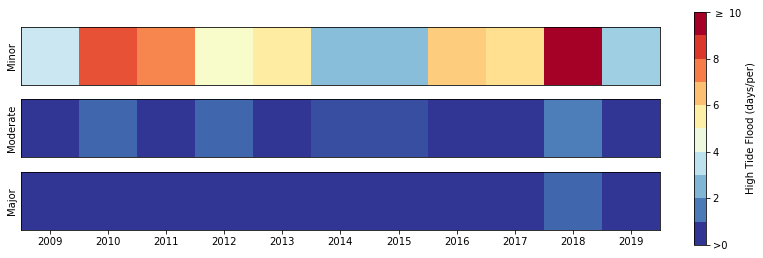

In [6]:
cmap=mpl.cm.get_cmap('RdYlBu_r')
bounds=np.arange(0,11,1)
norm = mpl.colors.BoundaryNorm(bounds,cmap.N)


cmap_name =cmap
vmin=0
vmax=df.values.max()

fig,ax = plt.subplots(3,1,figsize=(10,6))
c=ax[0].imshow(df[['minCount']].T,cmap=cmap_name,vmin=vmin,vmax=vmax)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_ylabel('Minor')

ax[1].imshow(df[['modCount']].T,cmap=cmap_name,vmin=vmin,vmax=vmax)
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_ylabel('Moderate')

ax[2].imshow(df[['majCount']].T,cmap=cmap_name,vmin=vmin,vmax=vmax)
ax[2].set_yticks([])
ax[2].set_ylabel('Major')


ax[2].set_xticks(range(len(df)), df.index)
fig.tight_layout(h_pad=-15)

cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap,norm=norm),ax=ax,fraction=0.017,label='High Tide Flood (days/per)')
cbar.ax.set_yticklabels(['>0','','2','','4','','6','','8','',r'$\geq\ $10'])


#### Here's where we change things! The next step pulls daily flood conts from the DPAPI in a slightly different format from annual counts because they are different products. Here, we are pulling daily counts for the period of one month. 

In [7]:
product = 'htf_daily'
station_id = '8665530'
start_date = '20200901'
end_date = '20200930'
datum = 'MHHW'
units = 'english'

server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/htf/"

my_url = (server+product+'.json?'+'station='+station_id+'&start_date='+start_date+'&end_date='+end_date+'&datum='+datum+'&units='+units)

urlResponse = requests.get(my_url)
content=urlResponse.json()

mydata=content['DailyFloodCount']
dailyflood = pd.DataFrame(mydata)

dailyflood

,day,maxWL,maxTime,majFlag,modFlag,minFlag,nanFlag
0,09/01/2020,0.96,0,0,0,0,0
1,09/02/2020,0.54,1,0,0,0,0
2,09/03/2020,0.36,1,0,0,0,0
3,09/04/2020,0.12,2,0,0,0,0
4,09/05/2020,-0.18,15,0,0,0,0
5,09/06/2020,0.49,15,0,0,0,0
6,09/07/2020,0.42,16,0,0,0,0
7,09/08/2020,0.45,17,0,0,0,0
8,09/09/2020,0.65,17,0,0,0,0
9,09/10/2020,0.35,18,0,0,0,0


### We will also pull NOS flood thresholds from the Meta Data API to plot with daily flood counts.

In [8]:
station_id = '8665530'
product='floodlevels'

units='english'

server = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/'

my_url = (server+'stations/'+station_id+'/'+product+'.json?units='+units)

# https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/8665530/floodlevels.json?units=english

urlResponse = requests.get(my_url)
content=urlResponse.json()

thresh = pd.DataFrame({'Minor':[content['nos_minor']],'Moderate':[content['nos_moderate']],'Major':[content['nos_major']]})


### Next, we use the Meta Data API to grab the Mean Higher High Water (MHHW) Datum. Flood thresholds are on Station Datum (STND), so we must subtract MHHW for the flood threshold to be on the same datum as our daily counts.

In [9]:
station_id = '8665530'
product2 = 'datums'
units='english'
server = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/'
my_url = (server+'stations/'+station_id+'/'+product2+'.json?units='+units)

urlResponse = requests.get(my_url)
content=urlResponse.json()
MHHW = content['datums'][1]['value']

#### This step plots Daily Max Water Levels for one month with the NOS flood thresholds - Minor, Moderate, Major. 

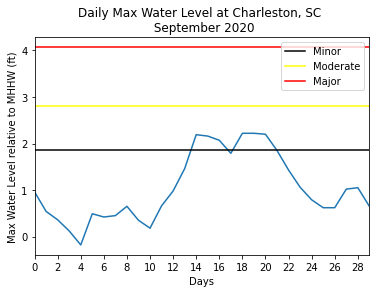

In [10]:
fig,ax=plt.subplots()
ax.plot(dailyflood['day'],dailyflood['maxWL'])
ax.set_xlim(dailyflood['day'].iloc[0],dailyflood['day'].iloc[-1])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

ax.axhline(thresh['Minor'][0]-MHHW,color='black',label='Minor')
ax.axhline(thresh['Moderate'][0]-MHHW,color='yellow',label='Moderate')
ax.axhline(thresh['Major'][0]-MHHW,color='red',label='Major')

ax.set_title('Daily Max Water Level at Charleston, SC \n September 2020')
ax.set_xlabel('Days')
ax.set_ylabel('Max Water Level relative to MHHW (ft)')

ax.legend()

#### This step builds the template to pull daily counts for one year. No plot will appear below when the function completes. 

In [11]:
product = 'htf_daily'
station_id = '8665530'
start_date = '20200101'
end_date = '20201231'
datum = 'MHHW'
units = 'english'

server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/htf/"

my_url = (server+product+'.json?'+'station='+station_id+'&start_date='+start_date+'&end_date='+end_date+'&datum='+datum+'&units='+units)

urlResponse = requests.get(my_url)
content=urlResponse.json()

mydata=content['DailyFloodCount']
dailyflood = pd.DataFrame(mydata)

#### This step plots a histogram of Daily High Water Levels by station for the period of a year. 

Text(0.5, 1.0, '2020 Histogram of Daily Highest Water Levels')

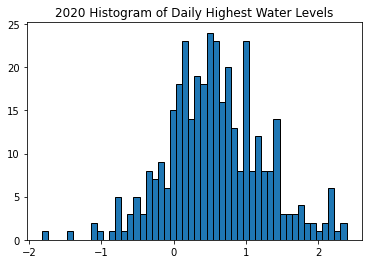

In [12]:
plt.hist(dailyflood['maxWL'],bins=50,edgecolor='black')
plt.title('2020 Histogram of Daily Highest Water Levels')

#### The next 3 modules prepare and plot a calendar of Daily High Water Levels above MHHW by station. 

In [13]:
dailyflood['day'] = pd.to_datetime(dailyflood['day'])

In [14]:
dailyflood=dailyflood.set_index('day')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 1440x216 with 2 Axes>,
 array([<AxesSubplot:ylabel='2020'>], dtype=object))

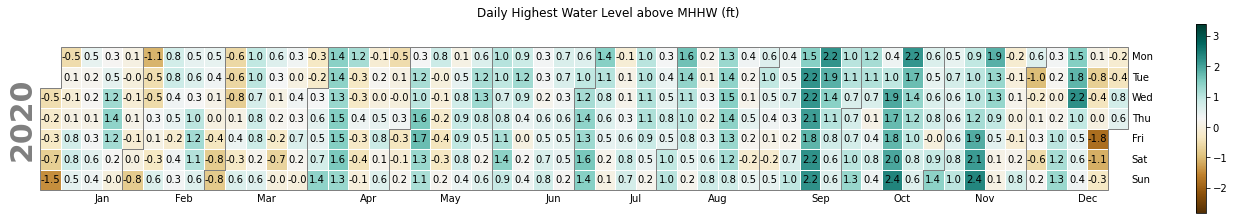

In [15]:
calplot.calplot(dailyflood['maxWL'],cmap='BrBG',vmin=dailyflood['maxWL'].min()-1,vmax=dailyflood['maxWL'].max()+1,suptitle='Daily Highest Water Level above MHHW (ft)',textformat='{:.1F}',textfiller='',figsize=(20,3)) 

#### The next two modules prepare and plot a calendar flagging instances of high tide flooding per day per year and by scenario threshold. 

In [16]:
colors = ['#f7f7f7','#2166ac']
cmap_name='my_list'
mycmap = LinearSegmentedColormap.from_list(cmap_name,colors,N=2)

Text(0.5, 0.92, '2020 Daily High Tide Flood Days')

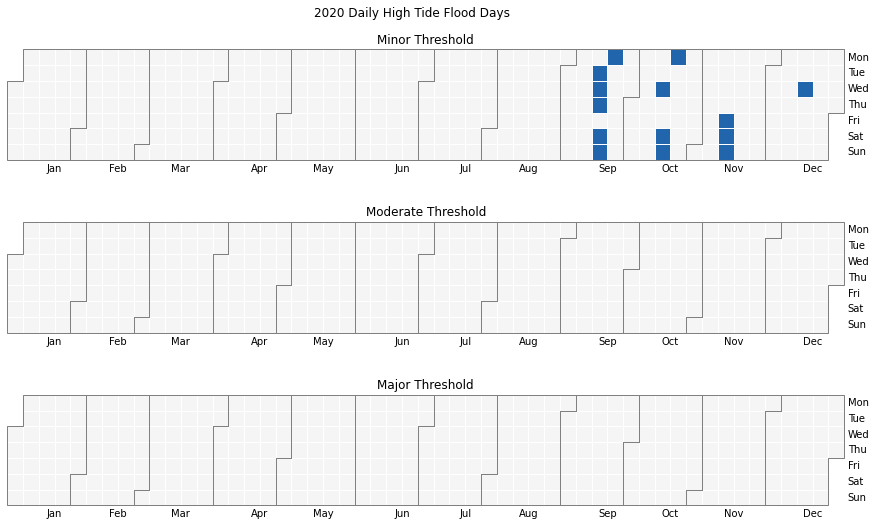

In [17]:
fig,ax = plt.subplots(3,1,figsize=(15,9))

calplot.yearplot(dailyflood['minFlag'],cmap=mycmap,vmin=int(0),vmax=int(1),ax=ax[0]) 
ax[0].set_title('Minor Threshold')

calplot.yearplot(dailyflood['modFlag'],cmap=mycmap,vmin=int(0),vmax=int(1),ax=ax[1]) 
ax[1].set_title('Moderate Threshold')
calplot.yearplot(dailyflood['majFlag'],cmap=mycmap,vmin=int(0),vmax=int(1),ax=ax[2]) 
ax[2].set_title('Major Threshold')

fig.suptitle('2020 Daily High Tide Flood Days',y=0.92)

#### We're switching gears again! The next two modules will create a table, then plot High Tide Flooding for the Next Met Year Annual Outlook. 

In [18]:
product = "htf_met_year_annual_outlook"
units='english'
met_year = '2018'
yrange='4'
station_id='8443970'
server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/htf/"

my_url = (server+product+ ".json?"+'station='+station_id+'&met_year='+met_year+'&range='+yrange+'&units='+units)


urlResponse = requests.get(my_url)
content=urlResponse.json()

mydata=content['MetYearAnnualOutlook']

metyr = pd.DataFrame(mydata)
metyr

,stnId,stnName,metYear,highConf,lowConf,projectDate,projectMethod
0,8443970,"Boston, MA",2019,19,12,2019-05-31,Quadratic
1,8443970,"Boston, MA",2020,18,11,2020-06-15,Quadratic
2,8443970,"Boston, MA",2021,18,11,2021-05-13,Quadratic


#### The following step plots a range of potential High Tide Flooding scenarios by year. Each bar represents a scenario. 

[Text(0, 3, '12'), Text(0, 3, '11'), Text(0, 3, '11')]

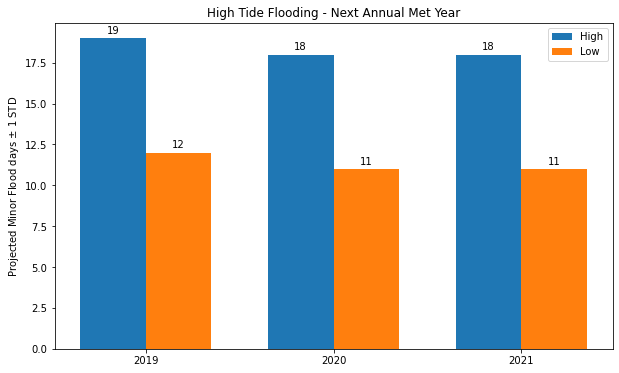

In [19]:

x = np.arange(len(metyr))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, metyr['highConf'], width, label='High')
rects2 = ax.bar(x + width/2, metyr['lowConf'], width, label='Low')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Projected Minor Flood days $\pm$ 1 STD')
ax.set_title('High Tide Flooding - Next Annual Met Year')
ax.set_xticks(x, metyr['metYear'])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

#### The next section creates the data frame for plotting high tide flooding values per scenario, by year. 

In [20]:
product = "htf_projection_annual"
units='english'
year = '2018'
yrange='4'
station_id='8443970'
server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/htf/"

my_url = (server+product+ ".json?"+'station='+station_id+'&year='+year+'&range='+yrange+'&units='+units)


urlResponse = requests.get(my_url)
content=urlResponse.json()
content
mydata=content['AnnualProjection']

annproj = pd.DataFrame(mydata)
annproj

,stnId,stnName,year,source,low,intLow,intermediate,intHigh,high,extreme
0,8443970,"Boston, MA",2021,https://tidesandcurrents.noaa.gov/publications...,16,19,28,40,51,56
1,8443970,"Boston, MA",2022,https://tidesandcurrents.noaa.gov/publications...,17,20,29,43,55,61


#### This step plots a histogram of Annual Projected Flood Days per scenario, by year. 

Text(0.5, 1.0, 'Annual Projected Flood Days per Scenario')

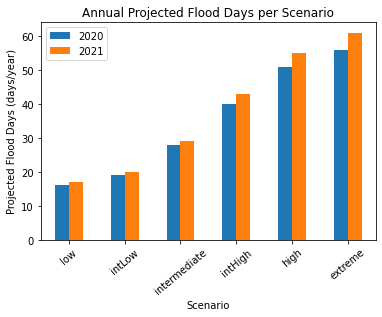

In [21]:
scen= annproj[annproj.columns[4:]].T
scen=scen.rename(columns={scen.columns[0]:'2020',scen.columns[1]:'2021'})
scen=scen.reset_index()
scen.plot(x='index',kind='bar',stacked=False)
plt.xlabel('Scenario')
plt.xticks(rotation=40)
plt.ylabel('Projected Flood Days (days/year)')
plt.title('Annual Projected Flood Days per Scenario')

#### The next two steps pull all Stations from the DPAPI for the year of 2021 to index HTF projections by station ID. Note, the Metadata API is used to pull lat/long from the Metadata API.

In [22]:
product = "htf_projection_annual"
units='english'
year = '2021'
yrange='0'

server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/htf/"

my_url = (server+product+ ".json?"+'&year='+year+'&range='+yrange+'&units='+units)


urlResponse = requests.get(my_url)
content=urlResponse.json()
content
mydata=content['AnnualProjection']

annproj = pd.DataFrame(mydata)
annproj = annproj.set_index('stnId')
annproj

,stnName,year,source,low,intLow,intermediate,intHigh,high,extreme
stnId,,,,,,,,,
1611400,"Nawiliwili, HI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,1,2
1612340,"Honolulu, HI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,1,2
1612480,"Mokuoloe, HI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,1,2
1615680,"Kahului, Kahului Harbor, HI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,1,2
1617433,"Kawaihae, HI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9449880,"Friday Harbor, WA",2021,https://tidesandcurrents.noaa.gov/publications...,5,5,6,8,10,11
9751401,"Lime Tree Bay, VI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,0,0
9751639,"Charlotte Amalie, VI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,0,0


In [23]:
uurl='https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations.json?type=waterlevels&units=english'
urlResponse = requests.get(uurl)
content=urlResponse.json()
content
mydata=content['stations']

stations= pd.DataFrame(mydata)

sidlatlon= stations[['id','lat','lng']]
sidlatlon=sidlatlon.rename(columns={'id':'stnId'})
sidlatlon = sidlatlon.set_index('stnId')

sidlatlon

,lat,lng
stnId,,
1611400,21.954400,-159.356100
1612340,21.306694,-157.867000
1612480,21.433056,-157.790000
1615680,20.895000,-156.476694
1617433,20.036600,-155.829400
...,...,...
9755371,18.459167,-66.116389
9757809,18.480528,-66.702361
9759110,17.970100,-67.046390


#### This step indexes the larger list of stations from the metadata API by the station ID from the DPAPI to create the lat/long subset to match the list of High Tide Flooding stations. 

In [24]:
df=sidlatlon

df = df.loc[df.index & annproj.index]
df

C:\TEMP\1/ipykernel_18456/1988911355.py:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  df = df.loc[df.index & annproj.index]


,lat,lng
stnId,,
1611400,21.954400,-159.356100
1612340,21.306694,-157.867000
1612480,21.433056,-157.790000
1615680,20.895000,-156.476694
1617433,20.036600,-155.829400
...,...,...
9449880,48.546700,-123.010002
9751401,17.694700,-64.753799
9751639,18.335833,-64.920000


#### This step concatinates the two data frames so we're plotting from one dataframe. 

In [25]:
annproj = annproj.join(df)
annproj

,stnName,year,source,low,intLow,intermediate,intHigh,high,extreme,lat,lng
stnId,,,,,,,,,,,
1611400,"Nawiliwili, HI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,1,2,21.954400,-159.356100
1612340,"Honolulu, HI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,1,2,21.306694,-157.867000
1612480,"Mokuoloe, HI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,1,2,21.433056,-157.790000
1615680,"Kahului, Kahului Harbor, HI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,1,2,20.895000,-156.476694
1617433,"Kawaihae, HI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,0,0,20.036600,-155.829400
...,...,...,...,...,...,...,...,...,...,...,...
9449880,"Friday Harbor, WA",2021,https://tidesandcurrents.noaa.gov/publications...,5,5,6,8,10,11,48.546700,-123.010002
9751401,"Lime Tree Bay, VI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,0,0,17.694700,-64.753799
9751639,"Charlotte Amalie, VI",2021,https://tidesandcurrents.noaa.gov/publications...,0,0,0,0,0,0,18.335833,-64.920000


#### This step creates a geospatial map of Projected High Tide Flooding days for all stations, by scenario and by year. 

C:\Users\julia.engdahl\Miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\julia.engdahl\Miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


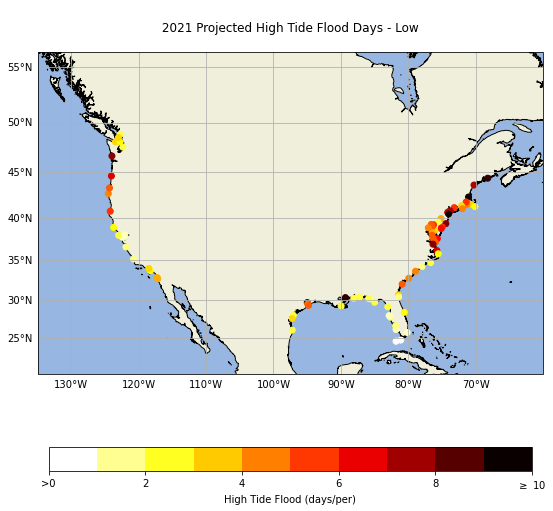

In [26]:
cmap=mpl.cm.get_cmap('hot_r')
bounds=np.arange(0,11,1)
norm = mpl.colors.BoundaryNorm(bounds,cmap.N)


proj = ccrs.Mercator()
data_crs = ccrs.PlateCarree()

plt.figure(figsize=(8,8))
ax=plt.axes(projection=proj)
ax.coastlines('10m')
gl=ax.gridlines(draw_labels=True)
gl.ylabels_right=False
gl.xlabels_top=False
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.set_extent([-135, -60, 20, 50])#, ccrs.Geodetic())

ax.scatter(annproj['lng'],annproj['lat'],c=annproj['low'],cmap=cmap,transform=data_crs)

ax.set_title('\n 2021 Projected High Tide Flood Days - Low \n')
cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap,norm=norm),ax=ax,fraction=0.05,label='High Tide Flood (days/per)',orientation='horizontal')
cbar.ax.set_xticklabels(['>0','','2','','4','','6','','8','',r'$\geq\ $10'])

plt.tight_layout(pad=3)

#### In this final step, we re-create a heat map like the one above to form a sub plot for each station and each scenario, by year. 

Text(0.5, 0.98, '2021 High Tide Flooding Projections per Scenario')

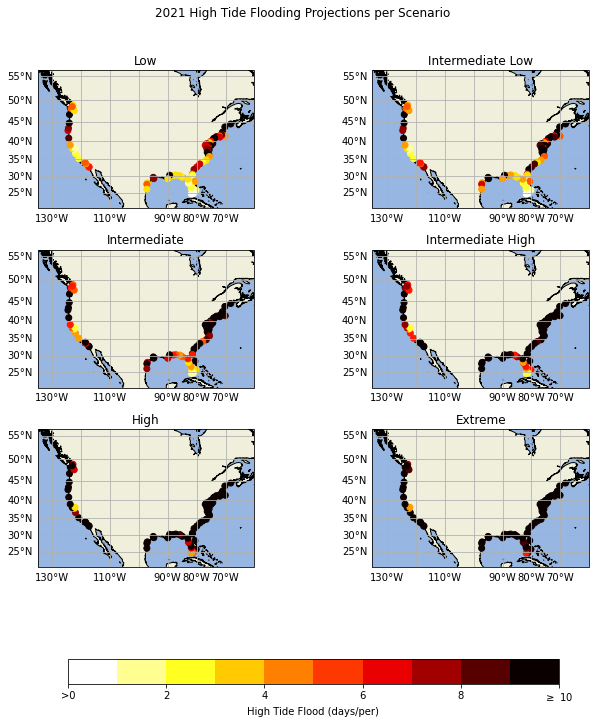

In [27]:
cmap=mpl.cm.get_cmap('hot_r')
bounds=np.arange(0,11,1)
norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
vmin=0
vmax=10

proj = ccrs.Mercator()
data_crs = ccrs.PlateCarree()

fig, ax = plt.subplots(3,2,figsize=(12,11),subplot_kw={'projection':proj},squeeze=False)


ax[0,0].coastlines('10m')
gl=ax[0,0].gridlines(draw_labels=True)
gl.ylabels_right=False
gl.xlabels_top=False
ax[0,0].add_feature(cfeature.OCEAN)
ax[0,0].add_feature(cfeature.LAND)
ax[0,0].set_extent([-135, -60, 20, 50])#, ccrs.Geodetic())

ax[0,0].scatter(annproj['lng'],annproj['lat'],c=annproj['low'],cmap=cmap,transform=data_crs,vmin=vmin,vmax=vmax)

ax[0,0].set_title('Low')



ax[0,1].coastlines('10m')
gl=ax[0,1].gridlines(draw_labels=True)
gl.ylabels_right=False
gl.xlabels_top=False
ax[0,1].add_feature(cfeature.OCEAN)
ax[0,1].add_feature(cfeature.LAND)
ax[0,1].set_extent([-135, -60, 20, 50])#, ccrs.Geodetic())

ax[0,1].scatter(annproj['lng'],annproj['lat'],c=annproj['intLow'],cmap=cmap,transform=data_crs,vmin=vmin,vmax=vmax)

ax[0,1].set_title('Intermediate Low')



ax[1,0].coastlines('10m')
gl=ax[1,0].gridlines(draw_labels=True)
gl.ylabels_right=False
gl.xlabels_top=False
ax[1,0].add_feature(cfeature.OCEAN)
ax[1,0].add_feature(cfeature.LAND)
ax[1,0].set_extent([-135, -60, 20, 50])#, ccrs.Geodetic())

ax[1,0].scatter(annproj['lng'],annproj['lat'],c=annproj['intermediate'],cmap=cmap,transform=data_crs,vmin=vmin,vmax=vmax)

ax[1,0].set_title('Intermediate')


ax[1,1].coastlines('10m')
gl=ax[1,1].gridlines(draw_labels=True)
gl.ylabels_right=False
gl.xlabels_top=False
ax[1,1].add_feature(cfeature.OCEAN)
ax[1,1].add_feature(cfeature.LAND)
ax[1,1].set_extent([-135, -60, 20, 50])#, ccrs.Geodetic())

ax[1,1].scatter(annproj['lng'],annproj['lat'],c=annproj['intHigh'],cmap=cmap,transform=data_crs,vmin=vmin,vmax=vmax)

ax[1,1].set_title('Intermediate High')




ax[2,0].coastlines('10m')
gl=ax[2,0].gridlines(draw_labels=True)
gl.ylabels_right=False
gl.xlabels_top=False
ax[2,0].add_feature(cfeature.OCEAN)
ax[2,0].add_feature(cfeature.LAND)
ax[2,0].set_extent([-135, -60, 20, 50])#, ccrs.Geodetic())

ax[2,0].scatter(annproj['lng'],annproj['lat'],c=annproj['high'],cmap=cmap,transform=data_crs,vmin=vmin,vmax=vmax)

ax[2,0].set_title('High')



ax[2,1].coastlines('10m')
gl=ax[2,1].gridlines(draw_labels=True)
gl.ylabels_right=False
gl.xlabels_top=False
ax[2,1].add_feature(cfeature.OCEAN)
ax[2,1].add_feature(cfeature.LAND)
ax[2,1].set_extent([-135, -60, 20, 50])#, ccrs.Geodetic())

ax[2,1].scatter(annproj['lng'],annproj['lat'],c=annproj['extreme'],cmap=cmap,transform=data_crs,vmin=vmin,vmax=vmax)

ax[2,1].set_title('Extreme')

fig.subplots_adjust(hspace=0.3, wspace=0,top=0.9)
cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap,norm=norm),ax=ax,fraction=0.04,label='High Tide Flood (days/per)',orientation='horizontal')
cbar.ax.set_xticklabels(['>0','','2','','4','','6','','8','',r'$\geq\ $10'])

fig.suptitle('2021 High Tide Flooding Projections per Scenario')